In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist  # Import pdist
from sklearn import metrics
from scipy.spatial.distance import euclidean
import json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder_path = '/content/drive/Shareddrives/DSCI554 project/Data collection/mental_health_data/data1_MHA_dashboard'
filenames = os.listdir(folder_path)
result_df = pd.read_csv(f'{folder_path}/depression_age_df.csv')
result_df = result_df[['state','latitude','longitude']]
for filename in filenames:
    if '_age_' in filename:
        df = pd.read_csv(os.path.join(folder_path, filename))
        for col in df.columns:
            if '2023-all_ages' in col and '100K' in col:
                result_df = pd.merge(result_df,df[['state',f'{col}']],on="state",how='outer')

report_path = '/content/drive/Shareddrives/DSCI554 project/Data collection/mental_health_data/data2_MHA_report/2022_report'
filenames = os.listdir(report_path)
result_df2 = pd.read_csv(f'{report_path}/21_adults_with_substance_use_disorder_in_the_past_year.csv')
result_df2 = result_df2[['state']]
result_df2 = result_df2[result_df2['state'] != 'National']
target_filenames = {'21_adults_with_substance_use_disorder_in_the_past_year.csv':'adult_disorder',
                    '26_youth_with_substance_use_disorder_in_the_past_year.csv':'youth_disorder',
                    '31_adults_with_cognitive_disability_who_could_not_see_a_doctor_due_to_costs.csv':'adult_cognitive_disability',
                    '35_students_identified_with_emotional_disturbance_for_an_individualized_education_program.csv':'youth_cognitive_disability'}

for filename in filenames:
    if filename in target_filenames.keys():
        df = pd.read_csv(os.path.join(report_path, filename))
        df = df[['state','percent','number']]
        df = df[df['state'] != 'National']
        df.columns = ['state',f'{target_filenames[filename]}_percent',f'{target_filenames[filename]}_number']
        df[f'{target_filenames[filename]}_percent'] = pd.to_numeric(df[f'{target_filenames[filename]}_percent'], errors='coerce')
        df[f'{target_filenames[filename]}_number'] = pd.to_numeric(df[f'{target_filenames[filename]}_number'], errors='coerce')
        df[f'{target_filenames[filename]}_total_number'] = (df[f'{target_filenames[filename]}_number']) / (0.01*df[f'{target_filenames[filename]}_percent'])
        result_df2 = pd.merge(result_df2, df,on='state',how='outer')

extracted_result_df2 = pd.DataFrame(result_df2['state'].copy())

extracted_result_df2['cognitive_disability'] = 100*(
    result_df2['youth_cognitive_disability_number'] + result_df2['adult_cognitive_disability_number']
) / (
    result_df2['youth_cognitive_disability_total_number'] + result_df2['adult_cognitive_disability_total_number']
)

extracted_result_df2['disorder'] = 100*(
    result_df2['adult_disorder_number'] + result_df2['youth_disorder_number']
) / (
    result_df2['adult_disorder_total_number'] + result_df2['youth_cognitive_disability_number']
)

result_df = pd.merge(result_df,extracted_result_df2,on='state',how='outer')
result_df.columns = ['state','latitude','longitude','depression','psychosis','ptsd','suicide','trauma','cognitive_disability','disorder']

radar chart - average performance on mental health features

       depression  psychosis       ptsd    suicide      trauma  \
count   51.000000  51.000000  51.000000  51.000000   51.000000   
mean    30.668972  33.475846  13.422851  15.556723   70.347059   
std      4.718872   5.198890   3.290769   3.136680   14.215912   
min     21.950469  23.485920   7.154319   9.401156   42.000000   
25%     27.897307  30.017426  10.791477  13.475686   60.050000   
50%     30.516618  32.389270  13.494988  15.681878   72.300000   
75%     32.888320  35.235183  15.657248  17.408386   80.250000   
max     50.227045  56.368939  23.612171  25.659469  106.100000   

       cognitive_disability   disorder  
count             51.000000  51.000000  
mean              25.506653   8.506061  
std                4.133759   1.290740  
min               17.761882   6.307285  
25%               21.905363   7.632480  
50%               25.260255   8.273193  
75%               28.245895   9.170565  
max               34.973245  12.633625  


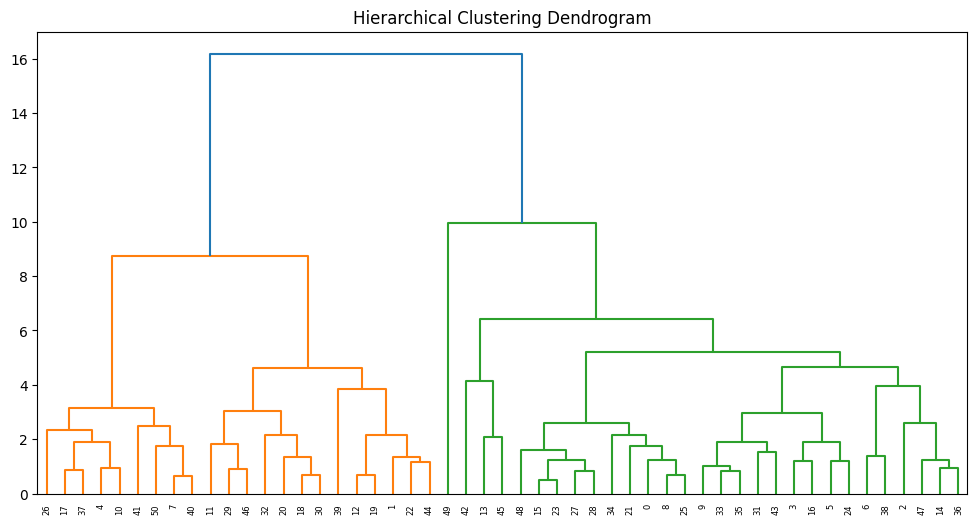

Cophenetic Correlation Coefficient: 0.506


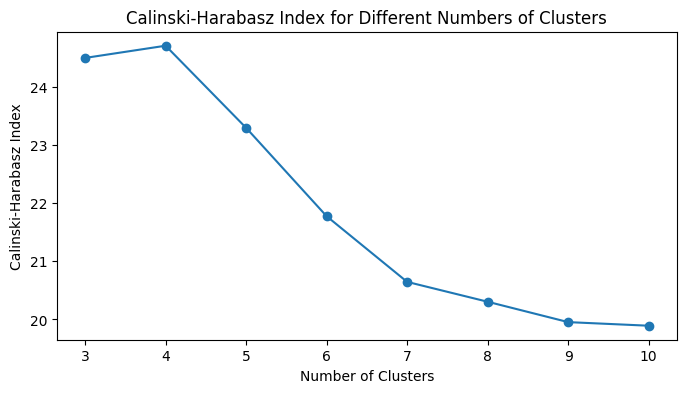

In [ ]:
mental_health_features = result_df[['depression', 'psychosis', 'ptsd', 'suicide', 'trauma', 'cognitive_disability', 'disorder']]
print(mental_health_features.describe())
# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(mental_health_features)

# Perform hierarchical clustering
linkage_method = 'ward'  # You can try other methods as well
linkage_matrix = linkage(scaled_features, method=linkage_method)

# Dendrogram
plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
dendrogram(linkage_matrix)
plt.show()

# Cophenetic correlation coefficient
c, coph_dists = cophenet(linkage_matrix, pdist(scaled_features))
print(f'Cophenetic Correlation Coefficient: {c:.3f}')

# Calinski-Harabasz Index
ch_scores = []
for n_clusters in range(3, 11):
    model = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage_method)
    labels = model.fit_predict(scaled_features)
    ch_score = metrics.calinski_harabasz_score(scaled_features, labels)
    ch_scores.append(ch_score)

# Plot Calinski-Harabasz Index
plt.figure(figsize=(8, 4))
plt.plot(range(3, 11), ch_scores, marker='o')
plt.title('Calinski-Harabasz Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.show()


In [ ]:
num_clusters = 4
clusters = fcluster(linkage_matrix, t=num_clusters, criterion='maxclust')

# Create a DataFrame with the original data and cluster assignments
result_df_with_clusters = pd.concat([result_df, pd.DataFrame({'hcluster': clusters}, index=result_df.index)], axis=1)
result_df_with_clusters
import plotly.graph_objects as go
result_df_with_clusters = result_df_with_clusters[['depression','psychosis','ptsd','suicide','cognitive_disability','disorder','hcluster']]
cluster_avg = result_df_with_clusters.groupby('hcluster').mean()
cluster_avg = pd.concat([cluster_avg.transpose(), pd.DataFrame(result_df_with_clusters.mean()[:-1])], axis=1).transpose()

# Create a radar chart with multiple traces for each cluster
fig = go.Figure()

for cluster in cluster_avg.index:
    fig.add_trace(go.Scatterpolar(
        r=cluster_avg.loc[cluster].values,
        theta=cluster_avg.columns,
        fill='toself',
        name=f'Cluster {cluster}'
    ))

fig.update_layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
        ),
    ),
    showlegend=True,
    title='Radar Chart for Clusters',
)

fig.show()

In [ ]:
d3_radar = dict()
for cluster, row in cluster_avg.iterrows():
    if cluster != 0:
        d3_radar[cluster] = [{'axis': column, 'value': value} for column, value in row.items()]
    else:
        d3_radar['mean'] = [{'axis': column, 'value': value} for column, value in row.items()]

json_data = json.dumps(d3_radar)
with open('radar_data.json', 'w') as json_file:
    json_file.write(json_data)

network - prevalence, cluster distance

In [ ]:
change_lat_lng = {42: [-72.4, 38.9],5: [-72.7678, 45.5584], 21: [-70.49, 43.66], 11: [-69.4757, 41.4966],44: [-72.7028, 40.9]}
for state_id, coordinate in change_lat_lng.items():
    result_df.loc[state_id,'latitude'] = coordinate[1]
    result_df.loc[state_id,'longitude'] = coordinate[0]

In [ ]:
report_path = '/content/drive/Shareddrives/DSCI554 project/Data collection/mental_health_data/data2_MHA_report/2022_report'
filenames = os.listdir(report_path)
prevalence_df = pd.read_csv(f'{report_path}/20_adult_prevalence_of_mental_illness.csv')
prevalence_df = prevalence_df[['state']]
prevalence_df = prevalence_df[prevalence_df['state'] != 'National']
target_filenames = {'20_adult_prevalence_of_mental_illness.csv':'adult_prevalence',
                    '25_youth_prevalence_of_mental_illness.csv':'youth_prevalence'}
for filename in filenames:
    if filename in target_filenames.keys():
        df = pd.read_csv(os.path.join(report_path, filename))
        df = df[['state','percent','number']]
        df = df[df['state'] != 'National']
        df.columns = ['state',f'{target_filenames[filename]}_percent',f'{target_filenames[filename]}_number']
        df[f'{target_filenames[filename]}_percent'] = pd.to_numeric(df[f'{target_filenames[filename]}_percent'], errors='coerce')
        df[f'{target_filenames[filename]}_number'] = pd.to_numeric(df[f'{target_filenames[filename]}_number'], errors='coerce')
        df[f'{target_filenames[filename]}_total_number'] = (df[f'{target_filenames[filename]}_number']) / (0.01*df[f'{target_filenames[filename]}_percent'])
        prevalence_df = pd.merge(prevalence_df, df,on='state',how='outer')

extracted_prevalence_df = pd.DataFrame(prevalence_df['state'].copy())

extracted_prevalence_df['prevalence_percent'] = 100*(
    prevalence_df['youth_prevalence_number'] + prevalence_df['adult_prevalence_number']
) / (
    prevalence_df['youth_prevalence_total_number'] + prevalence_df['adult_prevalence_total_number']
)
extracted_prevalence_df = pd.merge(result_df[['state','latitude','longitude']],extracted_prevalence_df,on='state', how ='outer')
# extracted_prevalence_df

In [ ]:
cluster_means = []
for cluster_id in np.unique(clusters):
    cluster_points = result_df_with_clusters[clusters == cluster_id]
    cluster_mean = np.mean(cluster_points, axis=0)
    cluster_means.append(cluster_mean)

nearest_nodes = []
for cluster_id, cluster_mean in zip(np.unique(clusters), cluster_means):
    cluster_points = result_df_with_clusters[clusters == cluster_id]
    nearest_node_index = np.argmin(np.linalg.norm(cluster_points - cluster_mean, axis=1))
    nearest_node = cluster_points.iloc[nearest_node_index]
    nearest_nodes.append(nearest_node)

In [ ]:
pairwise = []
stand_country_dict = {}
for idx, series in enumerate(nearest_nodes):
    nearest_node_id = series.name
    stand_country_dict[idx+1] = result_df.iloc[nearest_node_id][0]
    for point_id in result_df_with_clusters[clusters == idx+1].index:
        target_lat = result_df.iloc[point_id]['latitude']
        target_lng = result_df.iloc[point_id]['longitude']
        source_lat = result_df.iloc[nearest_node_id]['latitude']
        source_lng = result_df.iloc[nearest_node_id]['longitude']
        dist = euclidean(result_df_with_clusters.iloc[point_id], result_df_with_clusters.iloc[nearest_node_id])
        pairwise.append([idx+1, nearest_node_id,[source_lng,source_lat], point_id, [target_lng,target_lat],dist])
link_df = pd.DataFrame(pairwise, columns = ['cluster','source','source_coordinates','target','target_coordinates','relationship'])
node_df = pd.concat([extracted_prevalence_df, result_df_with_clusters[['hcluster']]], axis=1)
node_df['coordinates'] = node_df.apply(lambda row: [row['longitude'],row['latitude']], axis=1)
node_df = node_df[['state','prevalence_percent','hcluster','coordinates']]
node_df['id'] = node_df.index

In [ ]:
mean_pp = dict(node_df.groupby('hcluster')['prevalence_percent'].mean())
len_memeber = dict(node_df.groupby('hcluster')['id'].count())

mean_prevalence = []
stand_country_name = []
c_len_member = []
node_df[node_df['id'] == 17]['state']
for i in range(len(node_df)):
    mean_prevalence.append(mean_pp[node_df.iloc[i]['hcluster']])
    stand_country_name.append(stand_country_dict[node_df.iloc[i]['hcluster']])
    c_len_member.append(len_memeber[node_df.iloc[i]['hcluster']])
node_df = pd.concat([node_df, pd.DataFrame(mean_prevalence), pd.DataFrame(stand_country_name), pd.DataFrame(c_len_member)], axis=1)

In [ ]:
node_df.columns = ['state','prevalence_percent','hcluster','coordinates','id','mean_pervalence','representative','cluster_mem_number']
# node_df

In [ ]:
folder_path = '/content/drive/Shareddrives/DSCI554 project/Data collection/mental_health_data'
abbrv_df = pd.read_csv(f'{folder_path}/abbrv.csv')
node_df = pd.merge(node_df,abbrv_df,on='state',how='outer')
# node_df

In [ ]:
d3_network = {}
d3_network['nodes'] = node_df.to_dict(orient='records')
d3_network['links'] = link_df.to_dict(orient='records')

json_data = json.dumps(d3_network)

with open('network_data.json', 'w') as json_file:
    json_file.write(json_data)

In [ ]:
min(link_df['relationship'])

grouped bar chart - factors behind

In [ ]:
factor_df = pd.read_csv(f'{folder_path}/factor.csv')
factor_df = pd.merge(factor_df, node_df[['state','prevalence_percent','hcluster']],on='state',how='outer')

In [ ]:
scaler = StandardScaler()
scaled_factor = scaler.fit_transform(factor_df.iloc[:,1:9])
# len(scaled_factor[4 == factor_df['hcluster']])

In [ ]:
corr_df = pd.DataFrame()
for cluster_id in factor_df['hcluster'].unique():
    cluster_scaled_factor = pd.DataFrame(scaled_factor[cluster_id == factor_df['hcluster']])
    cluster_scaled_factor.columns = ['disability','unemployment','higher_education','uninsured','family_median_income','GDP','ACPSA','prevalence_percent']
    cluster_corr = cluster_scaled_factor.corr()
    corr_df = pd.concat([corr_df, pd.DataFrame(cluster_corr['prevalence_percent'])], axis=1)

cluster_scaled_factor = pd.DataFrame(scaled_factor)
cluster_scaled_factor.columns = ['disability','unemployment','higher_education','uninsured','family_median_income','GDP','ACPSA','prevalence_percent']
cluster_corr = cluster_scaled_factor.corr()
corr_df = pd.concat([corr_df, pd.DataFrame(cluster_corr['prevalence_percent'])], axis=1)
corr_df.columns = list(str(v) for v in factor_df['hcluster'].unique()) + ['total']
corr_df = corr_df.drop(columns = ['4'])
corr_df = corr_df.drop('prevalence_percent')
corr_df['name'] = ['disability rate','unemployment rate','higher education','healthcare uninsured','family income','state GDP','art and culture economic']
corr_dict = corr_df.to_dict(orient='records')

json_data = json.dumps(corr_dict)

with open('factor_corr.json', 'w') as json_file:
    json_file.write(json_data)


heatmap - health_pattern_by_age

In [ ]:
folder_path = '/content/drive/Shareddrives/DSCI554 project/Data collection/mental_health_data/data1_MHA_dashboard'
filenames = os.listdir(folder_path)
age_df = pd.read_csv(f'{folder_path}/depression_age_df.csv')
age_df = age_df[['state','latitude','longitude']]
for filename in filenames:
    if '_age_' in filename:
        df = pd.read_csv(os.path.join(folder_path, filename))
        for col in df.columns:
            if '100K' in col and 'all_years' not in col and 'all_ages' not in col and 'trauma' not in col:
                age_df = pd.merge(age_df,df[['state',f'{col}']],on="state",how='outer')


In [ ]:
result_age_df = pd.DataFrame(columns = ['state','value','year','label','issue'])

for col_id, col in enumerate(age_df.columns):
    if col_id not in [0,1,2]:
        age_df_temp = age_df[['state',col]]
        year = col.split('-')[0]
        label = col.split('-')[1]
        issue = col.split('-')[2]
        age_df_temp = pd.concat([age_df_temp,pd.DataFrame([year]*len(age_df_temp)),
                                pd.DataFrame([label]*len(age_df_temp)),
                                pd.DataFrame([issue]*len(age_df_temp))],axis=1)
        age_df_temp.columns = ['state','value','year','label','issue']
        result_age_df = pd.concat([result_age_df,age_df_temp],ignore_index=True)

In [ ]:
age_dict = {}
for state in result_age_df['state'].unique():
    age_dict[state] = result_age_df[result_age_df['state']==state].to_dict(orient = 'records')

result_mean_age_df = pd.DataFrame(columns = ['value','year','label','issue'])
mean_age_df = pd.DataFrame(age_df.mean()).transpose()
for col_id, col in enumerate(mean_age_df.columns):
    if col_id not in [0,1]:
        age_df_temp = mean_age_df[[col]]
        year = col.split('-')[0]
        label = col.split('-')[1]
        issue = col.split('-')[2]
        age_df_temp = pd.concat([age_df_temp,pd.DataFrame([year]*len(age_df_temp)),
                                pd.DataFrame([label]*len(age_df_temp)),
                                pd.DataFrame([issue]*len(age_df_temp))],axis=1)
        age_df_temp.columns = ['value','year','label','issue']
        result_mean_age_df = pd.concat([result_mean_age_df,age_df_temp],ignore_index=True)

age_dict['mean'] = result_mean_age_df.to_dict(orient='records')

In [ ]:
json_data = json.dumps(age_dict)

with open('age_year.json', 'w') as json_file:
    json_file.write(json_data)

state_prevalence

In [ ]:
state_df = pd.merge(result_df[['state','depression','suicide','ptsd','psychosis']], extracted_prevalence_df[['state','prevalence_percent']], on ='state',how='outer')

In [ ]:
state_dict = state_df.to_dict(orient='records')
json_data = json.dumps(state_dict)

with open('state_prevalence.json', 'w') as json_file:
    json_file.write(json_data)

In [ ]:
state_df.describe().transpose()[['count','mean','std','min','max']]

heatmap_race

In [ ]:
folder_path = '/content/drive/Shareddrives/DSCI554 project/Data collection/mental_health_data/data1_MHA_dashboard'
filenames = os.listdir(folder_path)
races_df = pd.read_csv(f'{folder_path}/depression_age_df.csv')
races_df = races_df[['state']]
for filename in filenames:
    if '_race_' in filename:
        df = pd.read_csv(os.path.join(folder_path, filename))
        for col in df.columns:
            if '2023' in col and '100K' in col and (('american' in col) or ('asian' in col) or ('black' in col) or ('hispanic' in col) or ('more_than_one' in col)):
                if ('ptsd' in col) or ('depression' in col) or ('suicide' in col) or ('psychosis' in col):
                    races_df = pd.merge(races_df,df[['state',f'{col}']],on="state",how='outer')
races_df.fillna(races_df.mean(numeric_only=True), inplace=True)

In [ ]:
races_name = {"american_indian_alaska_native":"American Indian/Alaska Native",
              "asian_pacific_islander":"Asian/Pacific Islander",
              "black_african_american":"Black/African American",
              "hispanic_latino":"Hispanic/Latino",
              "more_than_one":"Multiracial"}

In [ ]:
result_races_df = pd.DataFrame(columns = ['state','value','races','issue'])

for col_id, col in enumerate(races_df.columns):
    if col_id not in [0]:
        races_df_temp = races_df[['state',col]]
        races = races_name[col.split('-')[1]]
        issue = col.split('-')[2]
        races_df_temp = pd.concat([races_df_temp,
                                pd.DataFrame([races]*len(races_df_temp)),
                                pd.DataFrame([issue]*len(races_df_temp))],axis=1)
        races_df_temp.columns =['state','value','races','issue']
        result_races_df = pd.concat([result_races_df,races_df_temp],ignore_index=True)

In [ ]:
races_dict = {}
for state in result_races_df['state'].unique():
    races_dict[state] = result_races_df[result_races_df['state']==state].to_dict(orient = 'records')


In [ ]:

result_mean_races_df = pd.DataFrame(columns =['value','races','issue'])
mean_races_df = pd.DataFrame(races_df.mean()).transpose()

for col_id, col in enumerate(mean_races_df.columns):
    if col_id not in []:
        races_df_temp = mean_races_df[[col]]
        races = races_name[col.split('-')[1]]
        issue = col.split('-')[2]
        races_df_temp = pd.concat([races_df_temp,
                                pd.DataFrame([races]*len(races_df_temp)),
                                pd.DataFrame([issue]*len(races_df_temp))],axis=1)
        races_df_temp.columns = ['value','races','issue']
        result_mean_races_df = pd.concat([result_mean_races_df,races_df_temp],ignore_index=True)

races_dict['mean'] = result_mean_races_df.to_dict(orient='records')

In [ ]:
json_data = json.dumps(races_dict)

with open('races_2023.json', 'w') as json_file:
    json_file.write(json_data)